*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*
  
Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.0.2

torch: 2.6.0+cu126



# Model Zoo -- CNN Gender Classifier (ResNet-101 Architecture, CelebA) with Data Parallelism

### Network Architecture

The network in this notebook is an implementation of the ResNet-101 [1] architecture on the CelebA face dataset [2] to train a gender classifier.  
本笔记本中的网络是基于CelebA人脸数据集[2]实现的ResNet-101 [1]架构，用于训练性别分类器。

References  
参考文献

- [1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778). ([CVPR Link](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html))  
- [1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). 深度残差学习用于图像识别。在IEEE计算机视觉与模式识别会议论文集（第770-778页）。([CVPR 链接](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html))

- [2] Zhang, K., Tan, L., Li, Z., & Qiao, Y. (2016). Gender and smile classification using deep convolutional neural networks. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition Workshops (pp. 34-38).  
- [2] Zhang, K., Tan, L., Li, Z., & Qiao, Y. (2016). 使用深度卷积神经网络进行性别和微笑分类。在IEEE计算机视觉与模式识别会议研讨会论文集（第34-38页）。

The ResNet-101 architecture is similar to the ResNet-50 architecture, which is in turn similar to the ResNet-34 architecture shown below (from [1]) except that the ResNet 101 is using a Bottleneck block (compared to ResNet-34) and more layers than ResNet-50 (figure shows a screenshot from [1]):  
ResNet-101架构与ResNet-50架构相似，而ResNet-50架构又与下图所示的ResNet-34架构相似（来自[1]），不同之处在于ResNet-101使用了瓶颈块（与ResNet-34相比），并且比ResNet-50有更多的层（下图为[1]的截图）：

![](../images/resnets/resnet101/resnet101-arch-1.png)

The following figure illustrates residual blocks with skip connections such that the input passed via the shortcut matches the dimensions of the main path's output, which allows the network to learn identity functions.
下图展示了具有跳跃连接的残差块，这样通过捷径传递的输入与主路径输出的维度匹配，从而使网络能够学习到恒等映射（identity functions）。

![](../images/resnets/resnet-ex-1-1.png)

The ResNet-34 architecture actually uses residual blocks with modified skip connections such that the input passed via the shortcut matches is resized to dimensions of the main path's output. Such a residual block is illustrated below:
ResNet-34架构实际上使用了具有修改后的跳跃连接的残差块，使得通过捷径传递的输入被调整为与主路径输出相同的尺寸。下图展示了这样的残差块：

![](../images/resnets/resnet-ex-1-2.png)

The ResNet-50/101/151 then uses a bottleneck as shown below:
ResNet-50/101/151则使用了瓶颈结构，如下图所示：

![](../images/resnets/resnet-ex-1-3.png)

For a more detailed explanation see the other notebook, [resnet-ex-1.ipynb](resnet-ex-1.ipynb).

## Imports

In [2]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import time

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Settings

In [3]:
##########################
### 参数设置
##########################

# 超参数设置
RANDOM_SEED = 1  # 随机种子，用于结果复现
LEARNING_RATE = 0.001  # 学习率，控制模型更新的步长
NUM_EPOCHS = 10  # 训练轮数，即整个训练集将被迭代的次数

# 网络结构配置
NUM_FEATURES = 128*128  # 输入特征数（例如图像尺寸为128x128像素）
NUM_CLASSES = 2  # 分类类别数（例如二分类问题：男性/女性）
BATCH_SIZE = 128  # 每个批次处理的样本数
DEVICE = 'cuda:0'  # 默认使用的GPU设备（例如第1块GPU）
GRAYSCALE = False  # 是否为灰度图像，False 表示使用彩色图像（3通道）

## Dataset

### Downloading the Dataset

Note that the ~200,000 CelebA face image dataset is relatively large (~1.3 Gb).  
请注意，约20万个CelebA人脸图像数据集相对较大（约1.3 Gb）。

The download link provided below was provided by the author on the official CelebA website at http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html.  
下面提供的下载链接是作者在官方CelebA网站（http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html）上提供的。

1) Download and unzip the file `img_align_celeba.zip`, which contains the images in jpeg format.  
   下载并解压`img_align_celeba.zip`文件，该文件包含以jpeg格式存储的图像。

2) Download the `list_attr_celeba.txt` file, which contains the class labels.  
   下载`list_attr_celeba.txt`文件，该文件包含类标签。

3) Download the `list_eval_partition.txt` file, which contains training/validation/test partitioning info.  
   下载`list_eval_partition.txt`文件，该文件包含训练/验证/测试数据集划分信息。

### Preparing the Dataset

In [4]:
df1 = pd.read_csv('list_attr_celeba.txt', sep="\s+", skiprows=1, usecols=['Male'])  # 读取数据文件，分隔符为多个空格，跳过第一行，只选择'Male'列

# 将-1（女性）和1（男性）标签转换为0（女性）和1（男性）
df1.loc[df1['Male'] == -1, 'Male'] = 0  # 将'Male'列中值为-1的项替换为0

df1.head()  # 显示数据框的前几行

,Male
000001.jpg,0
000002.jpg,0
000003.jpg,1
000004.jpg,0
000005.jpg,0


In [5]:
df2 = pd.read_csv('list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
df2.columns = ['Filename', 'Partition']
df2 = df2.set_index('Filename')

df2.head()

,Partition
Filename,
000001.jpg,0
000002.jpg,0
000003.jpg,0
000004.jpg,0
000005.jpg,0


In [6]:
df3 = df1.merge(df2, left_index=True, right_index=True)
df3.head()

,Male,Partition
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,1,0
000004.jpg,0,0
000005.jpg,0,0


In [7]:
df3.to_csv('celeba-gender-partitions.csv')
df4 = pd.read_csv('celeba-gender-partitions.csv', index_col=0)
df4.head()

,Male,Partition
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,1,0
000004.jpg,0,0
000005.jpg,0,0


In [8]:
df4.loc[df4['Partition'] == 0].to_csv('celeba-gender-train.csv')
df4.loc[df4['Partition'] == 1].to_csv('celeba-gender-valid.csv')
df4.loc[df4['Partition'] == 2].to_csv('celeba-gender-test.csv')

(218, 178, 3)


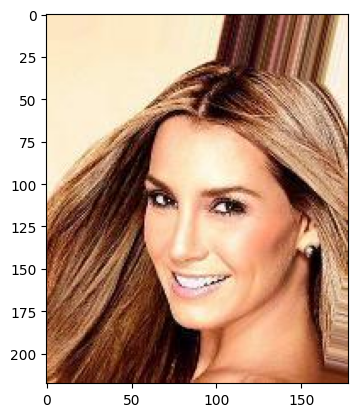

In [9]:
img = Image.open('img_align_celeba/000001.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

### Implementing a Custom DataLoader Class

In [10]:
class CelebaDataset(Dataset):
    """用于加载CelebA人脸图像的自定义数据集"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [11]:
# 注意 transforms.ToTensor() 已经会将像素值除以 255 进行归一化

custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),  # 中心裁剪图像，裁剪成 178x178 的大小
                                       transforms.Resize((128, 128)),  # 调整图像大小为 128x128
                                       #transforms.Grayscale(),  # 转为灰度图（可选）
                                       #transforms.Lambda(lambda x: x/255.),  # 将图像像素值除以 255（可选）
                                       transforms.ToTensor()])  # 将图像转换为 Tensor 类型，并归一化到 0-1 范围

# 创建训练数据集
train_dataset = CelebaDataset(csv_path='celeba-gender-train.csv',  # 训练数据的标签文件
                              img_dir='img_align_celeba/',  # 图像文件夹路径
                              transform=custom_transform)  # 应用自定义的数据预处理

# 创建验证数据集
valid_dataset = CelebaDataset(csv_path='celeba-gender-valid.csv',  # 验证数据的标签文件
                              img_dir='img_align_celeba/',  # 图像文件夹路径
                              transform=custom_transform)  # 应用自定义的数据预处理

# 创建测试数据集
test_dataset = CelebaDataset(csv_path='celeba-gender-test.csv',  # 测试数据的标签文件
                             img_dir='img_align_celeba/',  # 图像文件夹路径
                             transform=custom_transform)  # 应用自定义的数据预处理


# 创建训练数据加载器
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,  # 设置批次大小
                          shuffle=True,  # 打乱数据顺序
                          num_workers=4)  # 使用 4 个子进程加载数据

# 创建验证数据加载器
valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE,  # 设置批次大小
                          shuffle=False,  # 验证数据一般不打乱
                          num_workers=4)  # 使用 4 个子进程加载数据

# 创建测试数据加载器
test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,  # 设置批次大小
                         shuffle=False,  # 测试数据一般不打乱
                         num_workers=4)  # 使用 4 个子进程加载数据


In [12]:
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        time.sleep(1)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


## Model

The following code cell that implements the ResNet-34 architecture is a derivative of the code provided at https://pytorch.org/docs/0.4.0/_modules/torchvision/models/resnet.html.

In [13]:
##########################
### 模型定义
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """带有padding的3x3卷积层"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    """ResNet中的瓶颈模块（Bottleneck Block）"""
    expansion = 4  # 输出通道数的扩张倍数

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        # 1x1卷积：用于降维
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        # 3x3卷积：用于特征提取
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        # 1x1卷积：用于升维
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)  # 激活函数
        self.downsample = downsample  # 是否进行下采样的模块
        self.stride = stride  # 步幅设置

    def forward(self, x):
        residual = x  # 残差连接中的恒等映射分支

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)  # 对输入残差进行下采样匹配维度

        out += residual  # 残差连接
        out = self.relu(out)  # 激活输出

        return out


class ResNet(nn.Module):
    """ResNet 主体结构定义"""

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        in_dim = 1 if grayscale else 3  # 输入图像通道数（灰度图为1，彩色图为3）
        super(ResNet, self).__init__()

        # 初始卷积层
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 残差层堆叠
        self.layer1 = self._make_layer(block, 64, layers[0])      # 第1层残差模块
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)  # 第2层，空间尺寸减半
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)  # 第3层，继续下采样
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)  # 第4层

        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)  # 全局平均池化
        self.fc = nn.Linear(2048 * block.expansion, num_classes)  # 全连接输出层

        # 初始化权重
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**0.5)  # He初始化
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)  # 初始化BN层
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        """构建残差层，由多个Bottleneck Block堆叠"""
        downsample = None
        # 判断是否需要下采样：维度不匹配或stride不为1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        # 第一个block负责降采样
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        # 剩下的block保持尺寸
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)  # 初始卷积
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)  # 最大池化

        x = self.layer1(x)  # 通过各层残差模块
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)  # 全局平均池化
        x = x.view(x.size(0), -1)  # 扁平化
        logits = self.fc(x)  # 全连接层得到logits
        probas = F.softmax(logits, dim=1)  # 通过softmax得到概率分布
        return logits, probas  # 返回logits和概率


def resnet101(num_classes, grayscale):
    """构建 ResNet-101 模型"""
    model = ResNet(
        block=Bottleneck, 
        layers=[3, 4, 23, 3],  # ResNet-101 的层配置
        num_classes=NUM_CLASSES,  # 输出类别数
        grayscale=grayscale  # 是否为灰度图像
    )
    return model


In [14]:
torch.manual_seed(RANDOM_SEED)

##########################
### 损失函数和优化器
##########################

model = resnet101(NUM_CLASSES, GRAYSCALE)
model.to(DEVICE)

cost_fn = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Training

In [15]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = cost_fn(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Valid: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE),
              compute_accuracy(model, valid_loader, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/1272 | Cost: 0.7736
Epoch: 001/010 | Batch 0050/1272 | Cost: 0.6117
Epoch: 001/010 | Batch 0100/1272 | Cost: 0.3539
Epoch: 001/010 | Batch 0150/1272 | Cost: 0.2167
Epoch: 001/010 | Batch 0200/1272 | Cost: 0.1063
Epoch: 001/010 | Batch 0250/1272 | Cost: 0.1919
Epoch: 001/010 | Batch 0300/1272 | Cost: 0.2236
Epoch: 001/010 | Batch 0350/1272 | Cost: 0.1615
Epoch: 001/010 | Batch 0400/1272 | Cost: 0.1052
Epoch: 001/010 | Batch 0450/1272 | Cost: 0.1311
Epoch: 001/010 | Batch 0500/1272 | Cost: 0.1361
Epoch: 001/010 | Batch 0550/1272 | Cost: 0.1590
Epoch: 001/010 | Batch 0600/1272 | Cost: 0.2117
Epoch: 001/010 | Batch 0650/1272 | Cost: 0.0484
Epoch: 001/010 | Batch 0700/1272 | Cost: 0.1071
Epoch: 001/010 | Batch 0750/1272 | Cost: 0.0939
Epoch: 001/010 | Batch 0800/1272 | Cost: 0.0744
Epoch: 001/010 | Batch 0850/1272 | Cost: 0.0972
Epoch: 001/010 | Batch 0900/1272 | Cost: 0.0889
Epoch: 001/010 | Batch 0950/1272 | Cost: 0.1175
Epoch: 001/010 | Batch 1000/1272 | Cost:

## Evaluation

In [16]:
with torch.set_grad_enabled(False): # 在推理过程中禁用梯度计算，节省内存
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 97.28%


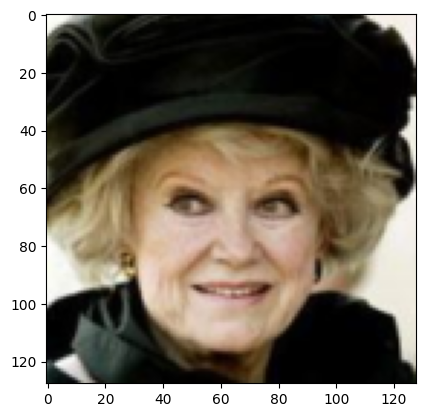

In [17]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
plt.imshow(np.transpose(features[0], (1, 2, 0)))

In [18]:
model.eval()
logits, probas = model(features.to(DEVICE)[0, None])
print('Probability Female %.2f%%' % (probas[0][0]*100))

Probability Female 99.95%


In [19]:
%watermark -iv

matplotlib : 3.10.1
torchvision: 0.21.0+cu126
PIL        : 11.1.0
pandas     : 2.2.3
numpy      : 1.26.4
torch      : 2.6.0+cu126

